# Handleiding: Opstellen van een Neuraal Netwerk met TensorFlow in Python

## Inhoudsopgave

1. [Introductie](#introductie)
2. [Benodigdheden](#benodigdheden)
3. [Data Voorbereiden](#data-voorbereiden)
4. [Model Bouwen](#model-bouwen)
5. [Model Compileren](#model-compileren)
6. [Model Trainen](#model-trainen)
7. [Model Evalueren](#model-evalueren)
8. [Voorspellingen Doen](#voorspellingen-doen)
9. [Model Opslaan en Laden](#model-opslaan-en-laden)
10. [Visualisaties (optioneel)](#visualisaties-optioneel)
11. [Vervolgstappen en Tips](#vervolgstappen-en-tips)

# Packages 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks, preprocessing
from sklearn.model_selection import train_test_split 
from keras.layers import Input, Dense, Conv1D, Flatten
from keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import keras
import keras_tuner as kt




print("VERSIES:")
print(f"{'- Pandas':<12} = {pd.__version__}")
print(f"{'- Numpy':<12} = {np.__version__}")
print(f"{'- Matplotlib':<12} = {plt.matplotlib.__version__}")
print(f"{'- Tensorflow':<12} = {tf.__version__}")
print(f"{'- Keras':<12} = {keras.__version__}")

VERSIES:
- Pandas     = 2.2.3
- Numpy      = 1.26.4
- Matplotlib = 3.10.1
- Tensorflow = 2.15.0
- Keras      = 2.15.0


# CV Inlezen

   Tijd (s)  Setpoint (m)  Hoogte (m)      Fout  Fout_Integratie  \
0      0.00       0.58079    0.004019  0.580790         0.005808   
1      0.01       0.58079    0.012057  0.576771         0.011576   
2      0.02       0.58079    0.024114  0.568733         0.017263   
3      0.03       0.58079    0.040190  0.556676         0.022830   
4      0.04       0.58079    0.060285  0.540600         0.028236   

   Fout_Afgeleide  PWM  
0        58.07896  1.0  
1        -0.40190  1.0  
2        -0.80380  1.0  
3        -1.20570  1.0  
4        -1.60760  1.0  
Index(['Tijd (s)', 'Setpoint (m)', 'Hoogte (m)', 'Fout', 'Fout_Integratie',
       'Fout_Afgeleide', 'PWM'],
      dtype='object')
           Tijd (s)  Setpoint (m)    Hoogte (m)          Fout  \
count  1.000001e+06  1.000001e+06  1.000001e+06  1.000001e+06   
mean   5.000000e+03  5.381822e-01  5.381686e-01  1.432880e-05   
std    2.886756e+03  2.742643e-01  2.782748e-01  4.725516e-02   
min    0.000000e+00  5.255000e-02  0.000000e+00 -9

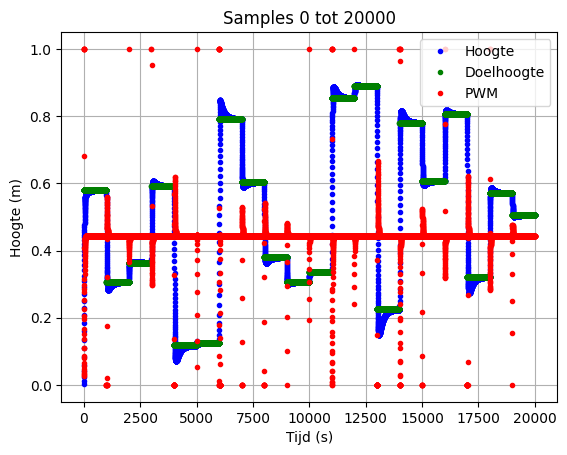

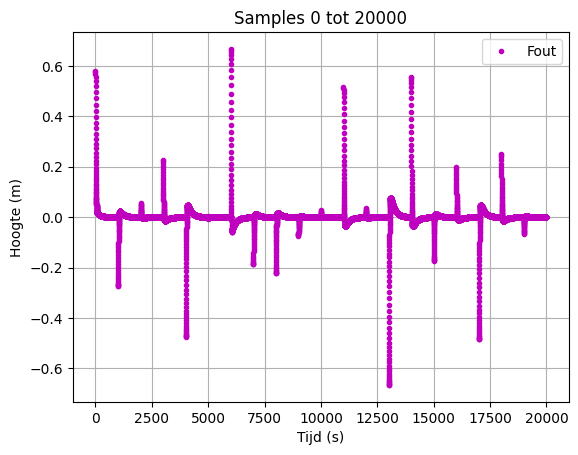

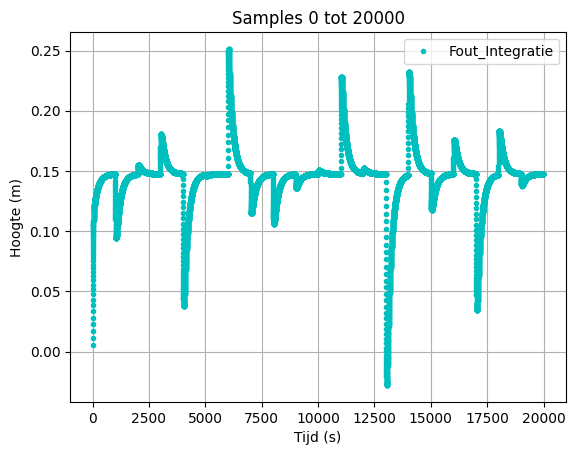

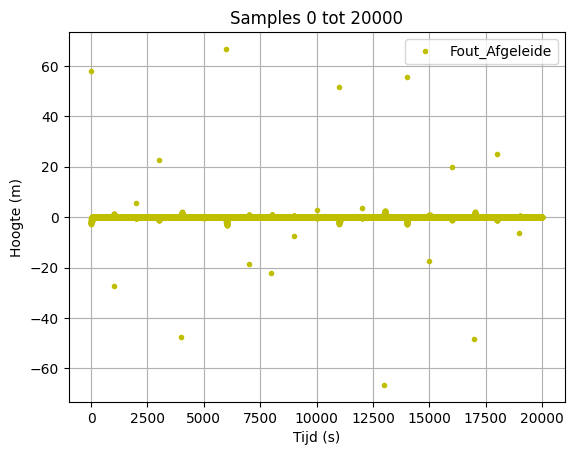

In [38]:


CSV_PATH = '/Users/mitchelreints/Desktop/05_Development/#Projecten/PEE51 - AIRegelsysteem/simulatie_resultaten.csv'
CSV_DATA = pd.read_csv(CSV_PATH)
print(CSV_DATA.head())
print(CSV_DATA.columns)
print(CSV_DATA.describe())
print(CSV_DATA.info())
print(CSV_DATA.shape)
print(CSV_DATA.dtypes)
print(CSV_DATA.isnull().sum())
print(CSV_DATA.nunique())
print(CSV_DATA.memory_usage(deep=True))
print(CSV_DATA)

# Toon aantal samples
total_samples = len(CSV_DATA)
print(f"Aantal samples: {total_samples}")
print(f"Indexbereik: 0 t/m {total_samples - 1}")

# Dynamisch start en end kiezen
start = 0
end = min(20000, total_samples)

# Veiligheidscheck
if end > start:
    x_range = range(start, end)

    plt.figure()
    plt.plot(x_range, CSV_DATA["Hoogte (m)"][start:end], 'b.', label="Hoogte")
    plt.plot(x_range, CSV_DATA["Setpoint (m)"][start:end], 'g.', label="Doelhoogte")
    plt.plot(x_range, CSV_DATA["PWM"][start:end], 'r.', label="PWM")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout"][start:end], 'm.', label="Fout")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout_Integratie"][start:end], 'c.', label="Fout_Integratie")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout_Afgeleide"][start:end], 'y.', label="Fout_Afgeleide")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.show()
else:
    print("⚠️ Niet genoeg samples om in dit bereik te plotten.")

In [39]:

# Selecteer features en target
features = CSV_DATA[['Setpoint (m)', 'Hoogte (m)', 'Fout', 'Fout_Integratie', 'Fout_Afgeleide']].to_numpy()
target = CSV_DATA['PWM'].to_numpy()

# # Normaliseer alleen de features
# feature_scaler = MinMaxScaler()
# features = feature_scaler.fit_transform(features_raw)

# Print informatie
print(f"Features shape: {features.shape}")
print(f"Target shape: {target.shape}\n")

print("🔹 Originele features (eerste 5 samples):")
print(features[:5])

print("\n🔸 Genormaliseerde features (eerste 5 samples):")
print(features[:5])

print("\n🎯 Target (eerste 5 waarden):")
print(target[:5])

# Voor inverse transform later:
# originele_features = feature_scaler.inverse_transform(features)



Features shape: (1000001, 5)
Target shape: (1000001,)

🔹 Originele features (eerste 5 samples):
[[ 5.807900e-01  4.019000e-03  5.807900e-01  5.808000e-03  5.807896e+01]
 [ 5.807900e-01  1.205700e-02  5.767710e-01  1.157600e-02 -4.019000e-01]
 [ 5.807900e-01  2.411400e-02  5.687330e-01  1.726300e-02 -8.038000e-01]
 [ 5.807900e-01  4.019000e-02  5.566760e-01  2.283000e-02 -1.205700e+00]
 [ 5.807900e-01  6.028500e-02  5.406000e-01  2.823600e-02 -1.607600e+00]]

🔸 Genormaliseerde features (eerste 5 samples):
[[ 5.807900e-01  4.019000e-03  5.807900e-01  5.808000e-03  5.807896e+01]
 [ 5.807900e-01  1.205700e-02  5.767710e-01  1.157600e-02 -4.019000e-01]
 [ 5.807900e-01  2.411400e-02  5.687330e-01  1.726300e-02 -8.038000e-01]
 [ 5.807900e-01  4.019000e-02  5.566760e-01  2.283000e-02 -1.205700e+00]
 [ 5.807900e-01  6.028500e-02  5.406000e-01  2.823600e-02 -1.607600e+00]]

🎯 Target (eerste 5 waarden):
[1. 1. 1. 1. 1.]


In [40]:
n_input = 2  # aantal tijdstappen per voorbeeld

X, y = [], []

for i in range(len(features) - n_input):
    X.append(features[i:i + n_input])
    y.append(target[i + n_input])  # de PWM bij het volgende moment

X = np.array(X)  # shape: (samples, n_input, features)
y = np.array(y)

print("X shape:", X.shape)  # (samples, tijdstappen, features)
print("y shape:", y.shape)  # (samples,)
print("X:", X)  # (samples, tijdstappen, features)
print("y:", y) 

X shape: (999999, 2, 5)
y shape: (999999,)
X: [[[ 5.807900e-01  4.019000e-03  5.807900e-01  5.808000e-03  5.807896e+01]
  [ 5.807900e-01  1.205700e-02  5.767710e-01  1.157600e-02 -4.019000e-01]]

 [[ 5.807900e-01  1.205700e-02  5.767710e-01  1.157600e-02 -4.019000e-01]
  [ 5.807900e-01  2.411400e-02  5.687330e-01  1.726300e-02 -8.038000e-01]]

 [[ 5.807900e-01  2.411400e-02  5.687330e-01  1.726300e-02 -8.038000e-01]
  [ 5.807900e-01  4.019000e-02  5.566760e-01  2.283000e-02 -1.205700e+00]]

 ...

 [[ 7.524410e-01  7.526530e-01 -2.140000e-04  1.480380e-01  1.180000e-04]
  [ 7.524410e-01  7.526520e-01 -2.130000e-04  1.480350e-01  1.170000e-04]]

 [[ 7.524410e-01  7.526520e-01 -2.130000e-04  1.480350e-01  1.170000e-04]
  [ 7.524410e-01  7.526510e-01 -2.120000e-04  1.480330e-01  1.160000e-04]]

 [[ 7.524410e-01  7.526510e-01 -2.120000e-04  1.480330e-01  1.160000e-04]
  [ 7.524410e-01  7.526500e-01 -2.110000e-04  1.480310e-01  1.160000e-04]]]
y: [1.       1.       1.       ... 0.442946 0.44

Test range: index 3000–202998
Train samples: 800000
Test samples: 199999


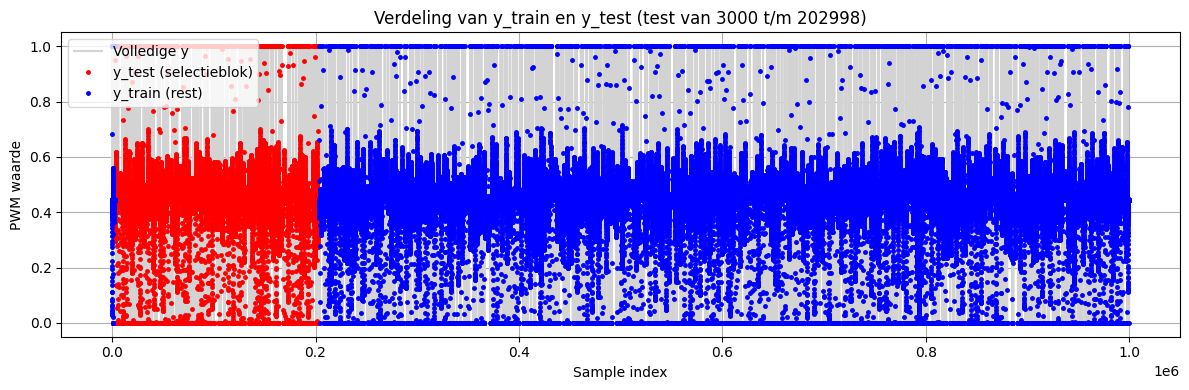

In [41]:
# Lengte van dataset
n = len(y)

# Hoeveel samples is 20%
test_len = int(n * 0.2)

# Kies handmatig waar je testdata begint
test_start = 3000  # bijvoorbeeld index 3000
test_end = test_start + test_len

# Zorg dat je niet buiten de dataset gaat
assert test_end <= n, "Testblok gaat buiten dataset!"

# Slice y en X
X_test, y_test = X[test_start:test_end], y[test_start:test_end]
X_train = np.concatenate((X[:test_start], X[test_end:]), axis=0)
y_train = np.concatenate((y[:test_start], y[test_end:]), axis=0)

print(f"Test range: index {test_start}–{test_end-1}")
print(f"Train samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")


import matplotlib.pyplot as plt

full_indices = np.arange(len(y))
idx_test = np.arange(test_start, test_end)
idx_train = np.setdiff1d(full_indices, idx_test)

plt.figure(figsize=(12, 4))
plt.plot(full_indices, y, color='lightgray', label="Volledige y")
plt.plot(idx_test, y_test, 'r.', label="y_test (selectieblok)", markersize=5)
plt.plot(idx_train, y_train, 'b.', label="y_train (rest)", markersize=5)

plt.title(f"Verdeling van y_train en y_test (test van {test_start} t/m {test_end - 1})")
plt.xlabel("Sample index")
plt.ylabel("PWM waarde")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model aanmaken

In [42]:

# model = Sequential([
#     Conv1D(filters=8, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),  # 8 filters
#     Flatten(),
#     Dense(8, activation='relu'),  # Hidden layer 1
#     Dense(8, activation='relu'),  # Hidden layer 2
#     Dense(1)  # Output layer met 8 neuronen
# ])

# model = Sequential([
#     Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(1)  # Één PWM-waarde voorspellen
# ])

# model = Sequential([
#     Conv1D(filters=8, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),  # 8 filters
#     Flatten(),
#     Dense(8, activation='relu'),  # Hidden layer 1
#     Dense(8, activation='relu'),  # Hidden layer 2
#     Dense(1)  # Output layer met 8 neuronen
# ])

# print("n_input:", n_input)
# print("X.shape[2]:", X.shape[2])
# model.summary()

In [43]:
def model_builder(hp):
    model = Sequential()

    # Conv1D laag met tunable filters en kernel size
    model.add(Conv1D(
    filters=hp.Int('filters', 4, 32, step=4),
    kernel_size=hp.Int('kernel_size', 1, min(n_input, 5), step=1),  # max kernel_size aangepast aan input
    activation=hp.Choice('conv_activation', ['relu', 'tanh', 'sigmoid']),
    padding='same',  # voorkomt output <= 0
    input_shape=(n_input, X.shape[2])
))


    model.add(Flatten())

    # Hidden Dense layer 1
    model.add(Dense(
        units=hp.Int('dense1_units', min_value=4, max_value=64, step=4),
        activation=hp.Choice('dense1_activation', values=['relu', 'tanh', 'sigmoid'])
    ))

    # Hidden Dense layer 2
    model.add(Dense(
        units=hp.Int('dense2_units', min_value=4, max_value=64, step=4),
        activation=hp.Choice('dense2_activation', values=['relu', 'tanh', 'sigmoid'])
    ))

    # Output layer (voor regressie zonder activatie of 'sigmoid'/'softmax' voor classificatie)
    model.add(Dense(1))

    # Learning rate als hyperparameter
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse',  # pas aan als je classificatie doet
        metrics=['mae']  # pas aan indien nodig
    )

    return model

In [44]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_mae',  # of 'val_accuracy' bij classificatie
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_dense_tuning'
)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Beste Conv1D filters: {best_hps.get('filters')}
Beste kernel_size: {best_hps.get('kernel_size')}
Activatie Conv: {best_hps.get('conv_activation')}
Dense1: {best_hps.get('dense1_units')} units, activatie: {best_hps.get('dense1_activation')}
Dense2: {best_hps.get('dense2_units')} units, activatie: {best_hps.get('dense2_activation')}
Learning rate: {best_hps.get('learning_rate')}
""")




Trial 10 Complete [00h 02m 36s]
val_mae: 0.0022976831533014774

Best val_mae So Far: 0.0009137198212556541
Total elapsed time: 00h 26m 18s

Beste Conv1D filters: 16
Beste kernel_size: 2
Activatie Conv: relu
Dense1: 56 units, activatie: sigmoid
Dense2: 12 units, activatie: sigmoid
Learning rate: 0.001



# Model Compilen

In [45]:
# model.compile(optimizer='adam', loss='mse')

# Model Trainen

In [ ]:
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/30
25000/25000 [==============================] - 10s 383us/step - loss: 8.9882e-04 - mae: 0.0067 - val_loss: 3.1615e-04 - val_mae: 0.0021
Epoch 2/30
25000/25000 [==============================] - 9s 377us/step - loss: 3.2773e-04 - mae: 0.0048 - val_loss: 2.8589e-04 - val_mae: 0.0025
Epoch 3/30
25000/25000 [==============================] - 9s 374us/step - loss: 2.9760e-04 - mae: 0.0037 - val_loss: 2.8668e-04 - val_mae: 0.0042
Epoch 4/30
25000/25000 [==============================] - 9s 373us/step - loss: 2.8422e-04 - mae: 0.0030 - val_loss: 2.6574e-04 - val_mae: 0.0017
Epoch 5/30
25000/25000 [==============================] - 9s 376us/step - loss: 2.7793e-04 - mae: 0.0026 - val_loss: 2.6273e-04 - val_mae: 0.0018
Epoch 6/30
25000/25000 [==============================] - 9s 372us/step - loss: 2.7359e-04 - mae: 0.0024 - val_loss: 2.6980e-04 - val_mae: 0.0012
Epoch 7/30
25000/25000 [==============================] - 9s 374us/step - loss: 2.7174e-04 - mae: 0.0024 - val_loss: 2.6442

# Training en validation loss Plotten

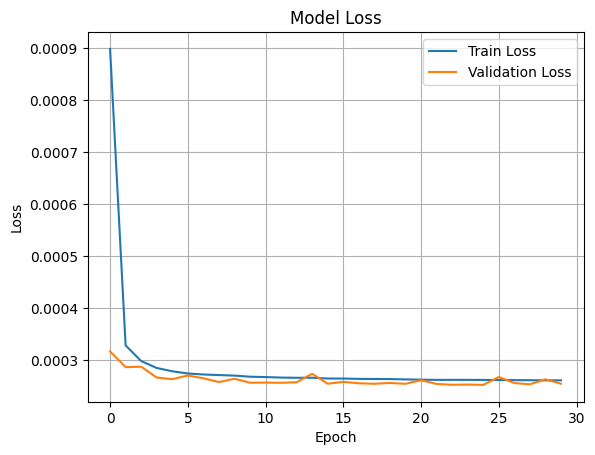

In [47]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(loss) + 1)


# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# PREDICT


6250/6250 [==============================] - 2s 251us/step - loss: 2.5387e-04 - mae: 9.6338e-04

loss : [0.0002538654371164739, 0.0009633800364099443]
y_test heeft 199999 samples (indexbereik: 0 t/m 199998)


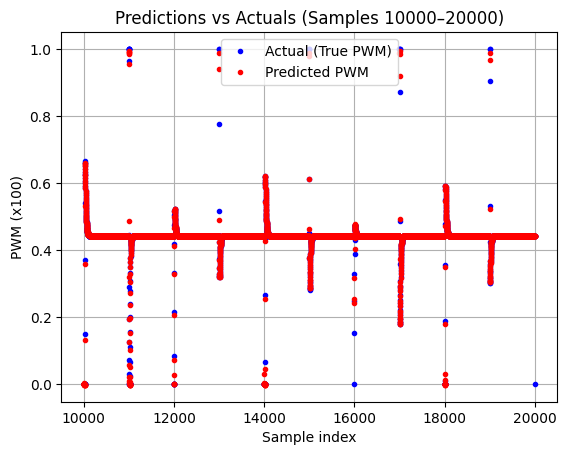

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Maak voorspellingen
predictions = model.predict(X_test).flatten()

score = model.evaluate(X_test, y_test)
print(f"\n{model.metrics_names[0]} : {score}")

print(f"y_test heeft {len(y_test)} samples (indexbereik: 0 t/m {len(y_test) - 1})")

# Stel de range in
start = 10000
end = min(20000, len(y_test)) 

# Plot alleen het gewenste bereik
plt.figure()
plt.title(f"Predictions vs Actuals (Samples {start}–{end})")
plt.plot(range(start, end), y_test[start:end], 'b.', label='Actual (True PWM)')
plt.plot(range(start, end), predictions[start:end], 'r.', label='Predicted PWM')
plt.xlabel("Sample index")
plt.ylabel("PWM (x100)")
plt.legend()
plt.grid(True)

plt.show()

In [49]:
model.save("pwm_model")


converter = tf.lite.TFLiteConverter.from_saved_model("pwm_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()
with open("pwm_model.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ Model succesvol getraind en geconverteerd(.tflite)")

INFO:tensorflow:Assets written to: pwm_model/assets


INFO:tensorflow:Assets written to: pwm_model/assets


✅ Model succesvol getraind en geconverteerd(.tflite)


2025-06-13 11:46:36.230888: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-06-13 11:46:36.231049: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-06-13 11:46:36.232963: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: pwm_model
2025-06-13 11:46:36.233526: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-06-13 11:46:36.233531: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: pwm_model
2025-06-13 11:46:36.235951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-06-13 11:46:36.236667: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-06-13 11:46:36.269023: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: pwm_model
2025-06-13 11:46:36.277513: 

# xxd -i pwm_model.tflite > pwm_model.cc